In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pandas as pd
csv_path = '/content/drive/My Drive/CartUp Project/dataset(in).csv'
df = pd.read_csv(csv_path)
df.head()

,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales
0,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,12/6/2017,16-06-17,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,11/10/2016,18-10-16,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,11/10/2016,18-10-16,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold N Roll Cart System,22.3680


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [23]:
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order_ID       9800 non-null   object 
 1   Order_Date     9800 non-null   object 
 2   Ship_Date      9800 non-null   object 
 3   Ship_Mode      9800 non-null   object 
 4   Customer_ID    9800 non-null   object 
 5   Customer_Name  9800 non-null   object 
 6   Segment        9800 non-null   object 
 7   Country        9800 non-null   object 
 8   City           9800 non-null   object 
 9   State          9800 non-null   object 
 10  Postal_Code    9789 non-null   float64
 11  Region         9800 non-null   object 
 12  Product_ID     9800 non-null   object 
 13  Category       9800 non-null   object 
 14  Sub_Category   9800 non-null   object 
 15  Product_Name   9800 non-null   object 
 16  Sales          9800 non-null   float64
dtypes: float64(2), object(15)
memory usage: 1.3+ MB


,0
Order_ID,0
Order_Date,0
Ship_Date,0
Ship_Mode,0
Customer_ID,0
Customer_Name,0
Segment,0
Country,0
City,0
State,0


In [24]:
# Standardize category names
df['Category'] = df['Category'].str.strip()

# Define discount and profit margin mappings
discount_map = {
    'Furniture': 0.1739,
    'Office Supplies': 0.2215,
    'Technology': 0.0520
}

profit_margin_map = {
    'Furniture': 0.1250,
    'Office Supplies': 0.0875,
    'Technology': 0.2530
}

# Assign values based on category
df['Discount'] = df['Category'].map(discount_map)
df['Profit_Margin'] = df['Category'].map(profit_margin_map)

# Calculate Profit and Discounted Sales
df['Profit'] = df['Sales'] * df['Profit_Margin']
df['Discounted_Sales'] = df['Sales'] * (1 - df['Discount'])

# Optional: round for cleaner output
#df[['Discount', 'Profit', 'Discounted_Sales']] = df[['Discount', 'Profit', 'Discounted_Sales']].round(2)

In [25]:
from dateutil.parser import parse

def safe_parse(date_str, dayfirst=False):
    try:
        return parse(date_str, dayfirst=dayfirst)
    except:
        return pd.NaT

# First, try default parsing (month-first)
df['Order_Date'] = df['Order_Date'].astype(str).apply(lambda x: safe_parse(x, dayfirst=False))
df['Ship_Date'] = df['Ship_Date'].astype(str).apply(lambda x: safe_parse(x, dayfirst=False))


In [26]:
from dateutil.parser import parse
import pandas as pd

# Helper function to safely parse a date
def safe_parse(date_str, dayfirst):
    try:
        return parse(date_str, dayfirst=dayfirst)
    except:
        return pd.NaT

# Function to select best (minimal positive) lead time combination
def resolve_dates(row):
    order_str = str(row['Order_Date'])
    ship_str = str(row['Ship_Date'])

    options = []

    for od_dayfirst in [False, True]:  # MM-DD or DD-MM
        for sd_dayfirst in [False, True]:
            od = safe_parse(order_str, dayfirst=od_dayfirst)
            sd = safe_parse(ship_str, dayfirst=sd_dayfirst)

            if pd.notna(od) and pd.notna(sd):
                lead = (sd - od).days
                if lead > 0:
                    options.append({
                        'Order_Date': od,
                        'Ship_Date': sd,
                        'Lead_Time': lead
                    })

    # Pick the one with minimum positive lead time
    if options:
        best = min(options, key=lambda x: x['Lead_Time'])
        return pd.Series([best['Order_Date'], best['Ship_Date'], best['Lead_Time']])
    else:
        return pd.Series([pd.NaT, pd.NaT, None])

# Apply to dataset
df[['Order_Date_Clean', 'Ship_Date_Clean', 'Lead_Time']] = df.apply(resolve_dates, axis=1)

# Optionally replace original columns
df['Order_Date'] = df['Order_Date_Clean']
df['Ship_Date'] = df['Ship_Date_Clean']
df.drop(['Order_Date_Clean', 'Ship_Date_Clean'], axis=1, inplace=True)

In [27]:
df.head()

,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,...,Product_ID,Category,Sub_Category,Product_Name,Sales,Discount,Profit_Margin,Profit,Discounted_Sales,Lead_Time
0,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,0.1739,0.1250,32.745000,216.405156,3
1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,0.1739,0.1250,91.492500,604.655634,3
2,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,...,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,0.2215,0.0875,1.279250,11.381670,4
3,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,...,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,0.1739,0.1250,119.697187,791.054773,7
4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,...,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold N Roll Cart System,22.3680,0.2215,0.0875,1.957200,17.413488,7


In [28]:
def format_number(n):
    if n >= 1e9:
        return f'{n/1e9:.1f}B'
    elif n >= 1e6:
        return f'{n/1e6:.1f}M'
    elif n >= 1e3:
        return f'{n/1e3:.1f}K'
    else:
        return f'{n:.0f}'

In [29]:
# Raw segment summary
segment_summary = df.groupby('Segment').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean'
}).reset_index()

# Rename columns
segment_summary.columns = ['Segment', 'Total Sales', 'Total Profit', 'Avg Discount']

# Create a formatted copy for display
formatted_segment_summary = segment_summary.copy()
formatted_segment_summary['Total Sales'] = formatted_segment_summary['Total Sales'].apply(format_number)
formatted_segment_summary['Total Profit'] = formatted_segment_summary['Total Profit'].apply(format_number)
formatted_segment_summary['Avg Discount'] = formatted_segment_summary['Avg Discount'].apply(lambda x: f'{x:.2%}')

# Display the formatted table
from IPython.display import display
print("📊 Segment Performance Summary")
display(formatted_segment_summary)

📊 Segment Performance Summary


,Segment,Total Sales,Total Profit,Avg Discount
0,Consumer,1.1M,181.4K,18.02%
1,Corporate,688.5K,108.9K,18.03%
2,Home Office,425.0K,71.9K,17.92%


/tmp/ipython-input-30-1656304771.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax)
/tmp/ipython-input-30-1656304771.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax)
/tmp/ipython-input-30-1656304771.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax)


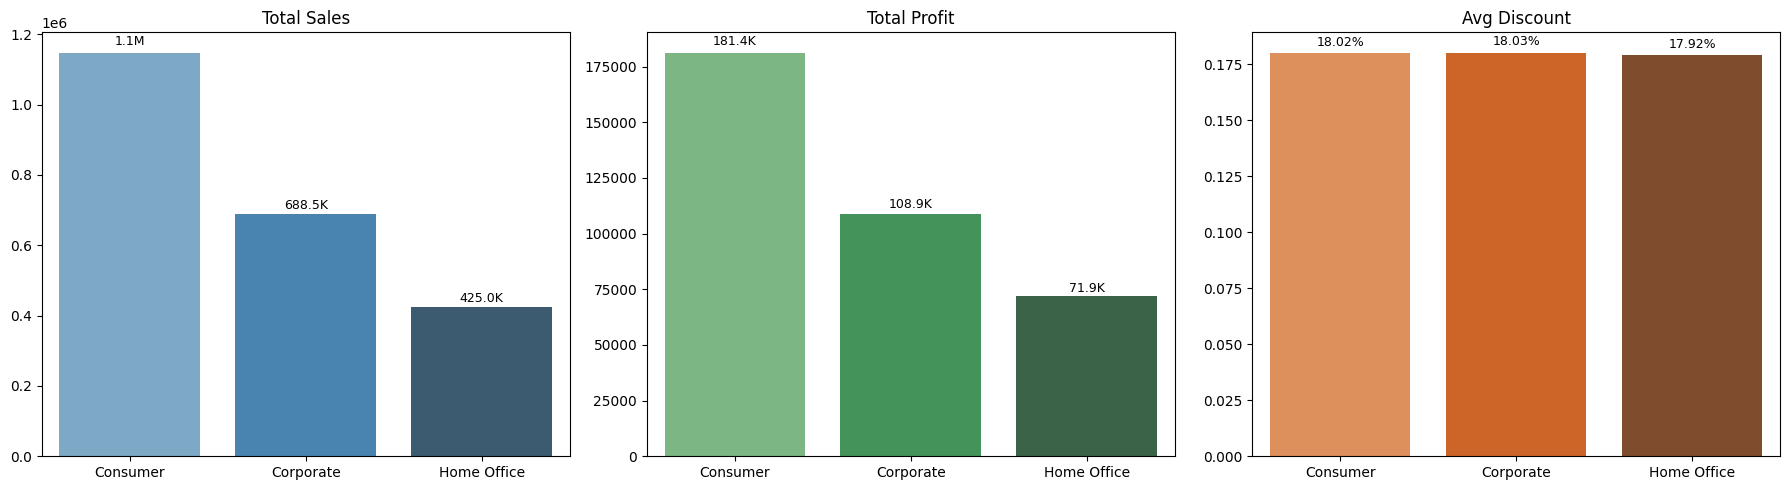

In [30]:
def barplot_with_labels(ax, data, x, y, title, palette, is_percent=False):
    sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax)
    for bar in ax.patches:
        height = bar.get_height()
        label = f'{height:.2%}' if is_percent else format_number(height)
        ax.text(bar.get_x() + bar.get_width() / 2,
                height + 0.01 * height,
                label,
                ha='center', va='bottom', fontsize=9)
    ax.set_title(title)
    ax.set_ylabel('')
    ax.set_xlabel('')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

barplot_with_labels(axes[0], segment_summary, 'Segment', 'Total Sales', 'Total Sales', 'Blues_d')
barplot_with_labels(axes[1], segment_summary, 'Segment', 'Total Profit', 'Total Profit', 'Greens_d')
barplot_with_labels(axes[2], segment_summary, 'Segment', 'Avg Discount', 'Avg Discount', 'Oranges_d', is_percent=True)

plt.tight_layout()
plt.show()

## 📌 Key Insights Summary

### 🧾 Sales by Segment
- **Consumer**: Highest sales (~1.1M)
- **Corporate**: Moderate (~688.5K)
- **Home Office**: Lowest (~425K)

➡ Consumer is the top revenue contributor.

---

### 💰 Profit by Segment
- **Consumer**: Highest profit (~181.4K)
- **Corporate**: Moderate (~108.9K)
- **Home Office**: Lowest (~71.9K)

➡ High sales in Consumer also yield high profits.

---

### 🏷️ Average Discount
- All segments have ~18% average discount.
  - Consumer: 18.02%
  - Corporate: 18.03%
  - Home Office: 17.92%

➡ Uniform discounts, but uneven profitability.

---

### 📉 Discount Impact
- Higher discounts **do not increase sales** significantly.
- **Profit decreases** as discount increases.

➡ Discounts reduce margins without boosting volume.

---

## ✅ Recommendations
- **Limit discounting** for low-profit segments (e.g., Home Office).
- **Focus on Consumer** for sustained growth.
- Use **targeted discounts**, not uniform ones.


In [31]:
# Calculate profit margin per segment
profit_margin = df.groupby('Segment').agg({
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index()

# Calculate average profit margin
profit_margin['Profit Margin'] = profit_margin['Profit'] / profit_margin['Sales']

# Format columns
formatted_margin = profit_margin.copy()
formatted_margin['Sales'] = formatted_margin['Sales'].apply(format_number)
formatted_margin['Profit'] = formatted_margin['Profit'].apply(format_number)
formatted_margin['Profit Margin'] = formatted_margin['Profit Margin'].apply(lambda x: f'{x:.2%}')

# Display
from IPython.display import display
print("💡 Average Profit Margin by Segment")
display(formatted_margin[['Segment', 'Sales', 'Profit', 'Profit Margin']])

💡 Average Profit Margin by Segment


,Segment,Sales,Profit,Profit Margin
0,Consumer,1.1M,181.4K,15.80%
1,Corporate,688.5K,108.9K,15.82%
2,Home Office,425.0K,71.9K,16.92%


/tmp/ipython-input-30-1656304771.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax)


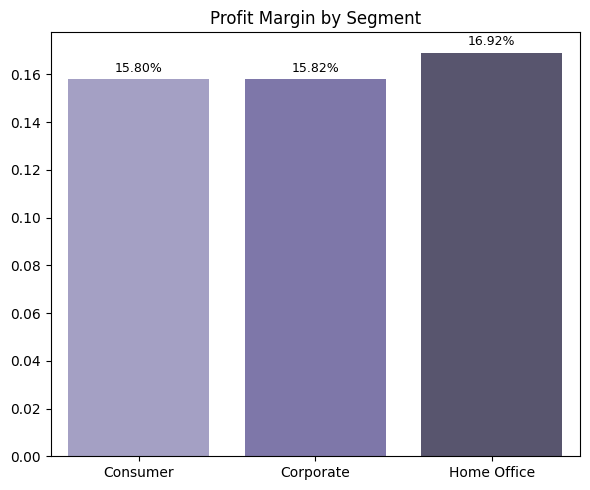

In [33]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(6, 5))

# Call your function with ax
barplot_with_labels(
    ax,                     # first argument: ax
    profit_margin,          # data
    'Segment',              # x-axis
    'Profit Margin',        # y-axis
    'Profit Margin by Segment',  # title
    'Purples_d',            # color palette
    is_percent=True         # whether to show % format
)

plt.tight_layout()
plt.show()

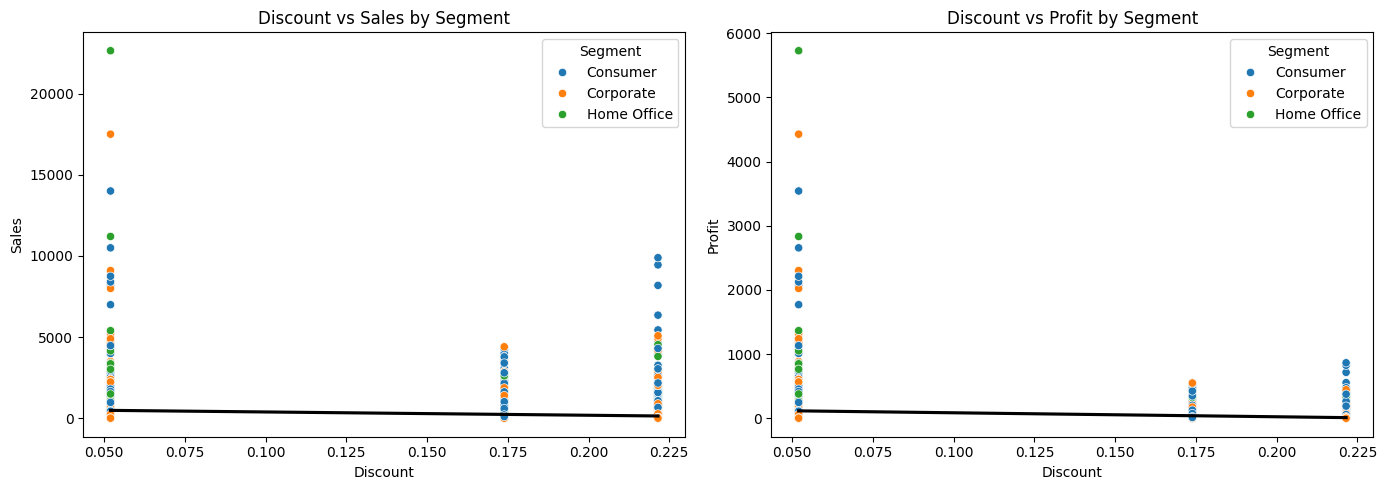

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Plot 1: Discount vs Sales
sns.scatterplot(data=df, x='Discount', y='Sales', hue='Segment', ax=axes[0])
sns.regplot(data=df, x='Discount', y='Sales', scatter=False, ax=axes[0], color='black')
axes[0].set_title('Discount vs Sales by Segment')
axes[0].legend(title='Segment')

# Plot 2: Discount vs Profit
sns.scatterplot(data=df, x='Discount', y='Profit', hue='Segment', ax=axes[1])
sns.regplot(data=df, x='Discount', y='Profit', scatter=False, ax=axes[1], color='black')
axes[1].set_title('Discount vs Profit by Segment')
axes[1].legend(title='Segment')

plt.tight_layout()
plt.show()

## 📊 Key Insights from Discount vs Sales & Profit Analysis

- 🔻 **Higher discounts do not lead to higher sales** — there's no strong positive correlation across any customer segment.
- 💸 **Profitability decreases as discounts increase** — trendlines show a clear negative relationship between discount levels and profit.
- 🎯 High-profit and high-sales transactions occur **even with minimal or no discounts**, especially in the **Consumer** and **Corporate** segments.
- 📉 **Home Office buyers** do not respond positively to discounts, indicating **discounts are not an effective incentive** for them.
- 📦 Discounts are applied in fixed tiers (e.g., 0.05, 0.17), but their **effectiveness is questionable across all segments**.

### 💡 Recommendation:
Avoid blanket discount strategies. Instead, apply **controlled, targeted discounts** where necessary, and explore **value-based or premium pricing models**, especially for segments like **Home Office**.


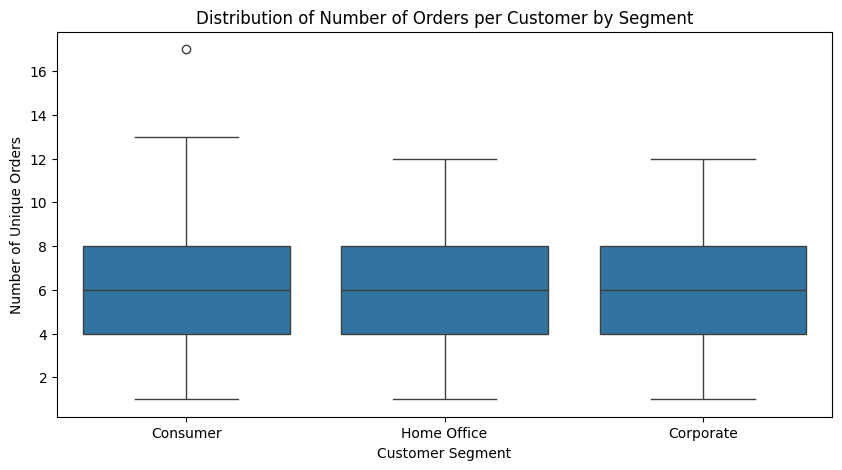

In [35]:
customer_orders = df.groupby('Customer_ID').agg({
    'Order_ID': pd.Series.nunique,
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean',
    'Segment': 'first'
}).reset_index()

plt.figure(figsize=(10,5))
sns.boxplot(data=customer_orders, x='Segment', y='Order_ID')
plt.title('Distribution of Number of Orders per Customer by Segment')
plt.ylabel('Number of Unique Orders')
plt.xlabel('Customer Segment')
plt.show()


In [36]:
# Aggregate customer-level data by Segment
segment_customer_summary = customer_orders.groupby('Segment').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean',
    'Order_ID': 'mean'  # avg number of orders per customer
}).reset_index()

# Calculate profit margin (Profit / Sales)
segment_customer_summary['Profit Margin'] = segment_customer_summary['Profit'] / segment_customer_summary['Sales']

# Optional: Format numbers nicely (reuse your format_number function for Sales, Profit)
segment_customer_summary['Total Sales'] = segment_customer_summary['Sales'].apply(format_number)
segment_customer_summary['Total Profit'] = segment_customer_summary['Profit'].apply(format_number)
segment_customer_summary['Avg Discount'] = segment_customer_summary['Discount'].apply(lambda x: f'{x:.2%}')
segment_customer_summary['Avg Orders per Customer'] = segment_customer_summary['Order_ID'].apply(lambda x: f'{x:.1f}')
segment_customer_summary['Profit Margin'] = segment_customer_summary['Profit Margin'].apply(lambda x: f'{x:.2%}')

# Select and reorder columns for display
display_columns = [
    'Segment',
    'Total Sales',
    'Total Profit',
    'Profit Margin',
    'Avg Discount',
    'Avg Orders per Customer'
]

from IPython.display import display
print("📋 Customer-Level Summary by Segment")
display(segment_customer_summary[display_columns])

📋 Customer-Level Summary by Segment


,Segment,Total Sales,Total Profit,Profit Margin,Avg Discount,Avg Orders per Customer
0,Consumer,1.1M,181.4K,15.80%,18.03%,6.2
1,Corporate,688.5K,108.9K,15.82%,18.09%,6.3
2,Home Office,425.0K,71.9K,16.92%,18.05%,6.0


### 🔍 Key Observations:

- **Consumer** and **Corporate** segments show **very similar profit margins (~15.8%)** and **average discounts (~18%)**, but **Consumer** generates **higher total sales and profit**.
- **Home Office** segment, despite having **lower total sales**, yields the **highest profit margin (16.92%)** and is the most **efficient in generating profit per dollar of sales**.
- **Average orders per customer** are quite consistent across segments (~6), suggesting similar engagement frequency.

---

### 💡 Insight:

- The **Home Office** segment is the **most efficient** in profitability, indicating that **deep discounts are not necessary** to drive value — ideal for **premium pricing** or **value-based upsells**.
- The **Consumer** segment contributes the **largest share of revenue and volume**, but slightly trails in efficiency, reinforcing the need for **strategic discount control and bundling** rather than broad markdowns.
- **Corporate** has a stable profile across all metrics, suggesting an opportunity for **tiered loyalty programs** or **volume-based pricing incentives** to maximize value.


In [37]:
unique_customers = df.groupby('Segment')['Customer_ID'].nunique().reset_index()
unique_customers.columns = ['Segment', 'Unique Customers']

from IPython.display import display
print("Unique Customers by Segment")
display(unique_customers)

Unique Customers by Segment


,Segment,Unique Customers
0,Consumer,409
1,Corporate,236
2,Home Office,148


### 🔍 Key Observations:

- The **Consumer** segment has the **largest customer base** with 409 unique customers, nearly **double** that of **Corporate** and almost **three times** that of **Home Office**.
- **Corporate** has a moderate-sized customer base (236), indicating solid B2B engagement.
- **Home Office** has the **smallest customer base** (148), suggesting a **niche audience** or limited outreach.

---

### 💡 Insight:

- The **Consumer** segment offers the largest reach, making it a prime target for **personalized promotions** and **high-frequency purchase incentives**.
- For **Home Office**, a **customer acquisition or loyalty strategy** could help grow the segment and increase profitability from a high-margin audience.

In [38]:
# Count total items ordered per segment (number of rows)
items_ordered = df.groupby('Segment').size().reset_index(name='Items Ordered')

# Sum sales and profit per segment
segment_sum = df.groupby('Segment').agg({
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index()

# Merge items ordered count with sums
summary = segment_sum.merge(items_ordered, on='Segment')

# Calculate average sales and profit per item ordered
summary['Avg Sales per Item'] = summary['Sales'] / summary['Items Ordered']
summary['Avg Profit per Item'] = summary['Profit'] / summary['Items Ordered']

# Format nicely (optional)
summary['Avg Sales per Item'] = summary['Avg Sales per Item'].apply(lambda x: f"${x:,.2f}")
summary['Avg Profit per Item'] = summary['Avg Profit per Item'].apply(lambda x: f"${x:,.2f}")
summary['Sales'] = summary['Sales'].apply(lambda x: f"${x:,.0f}")
summary['Profit'] = summary['Profit'].apply(lambda x: f"${x:,.0f}")

from IPython.display import display
print("Summary: Sales, Profit, Items Ordered, and Averages by Segment")
display(summary)

Summary: Sales, Profit, Items Ordered, and Averages by Segment


,Segment,Sales,Profit,Items Ordered,Avg Sales per Item,Avg Profit per Item
0,Consumer,"$1,148,061","$181,361",5101,$225.07,$35.55
1,Corporate,"$688,494","$108,894",2953,$233.15,$36.88
2,Home Office,"$424,982","$71,898",1746,$243.40,$41.18


### 🔍 Key Observations:

- **Consumer** segment generates the highest **total sales and profit**, but has the **lowest average profit per item** ($35.55).
- **Home Office** has the **smallest volume of items ordered** (1,746) but the **highest average profit per item** (\$41.18) and **average sales per item** (\$243.40).
- **Corporate** shows balanced performance, with mid-level totals and averages.

---

### 💡 Insight:

- **Consumer** purchases are high in volume but lower in margin — ideal for **volume-based strategies with controlled discounts**.
- **Home Office** purchases fewer items but at higher price and margin — a strong fit for **premium pricing strategies**.
- **Corporate** segment sits in between — suitable for **volume incentives or tiered pricing models**.


In [39]:
# Count number of rows (items) for each Segment × Category
segment_category_count = df.groupby(['Segment', 'Category']).size().reset_index(name='Items Ordered')

# Pivot to table format
pivot_table = segment_category_count.pivot(index='Segment', columns='Category', values='Items Ordered').fillna(0).astype(int)

from IPython.display import display
print("Number of Items Ordered by Segment and Category")
display(pivot_table)

Number of Items Ordered by Segment and Category


Category,Furniture,Office Supplies,Technology
Segment,,,
Consumer,1093,3072,936
Corporate,628,1783,542
Home Office,357,1054,335



### 🔍 Key Observations from the table:

- **Office Supplies** is the most frequently ordered category across all segments, especially by **Consumers** (3,072 items).
- The **Consumer** segment leads in total order volume across all categories.
- **Home Office** customers place significantly fewer orders overall, particularly in **Technology** (only 335 items), suggesting lower engagement or purchasing power in high-value items.
- **Corporate** buyers show a more balanced distribution but still prioritize Office Supplies.

---

### 💡 Insight:

**Office Supplies** drive the majority of purchases, especially for **Consumer** and **Home Office** segments — making it a strategic category for **targeted promotions or bundled offers**.

In contrast, **Technology** and **Furniture** may benefit from **premium positioning** or **awareness campaigns** in underperforming segments.

## 💼 Strategic Pricing Recommendations to Enhance Segment Profitability

## 🎯 Recommendation 1: Implement Targeted, Controlled Discounts for the Consumer Segment on Office Supplies

### Justification:
- The **Consumer** segment has the **highest number of items ordered overall (5,101)**, and **Office Supplies alone account for 3,072 items** (≈60% of their volume).
- Their **average profit per item is only $35.55**, indicating thinner margins due to possibly unnecessary discounts.
- **Scatterplot analysis** shows no meaningful increase in sales with higher discounts, but a **clear decline in profit**.

### Strategy:
- Apply **targeted discounts (5–10%)** only on high-volume Office Supplies, not across all products.
- **Bundle frequently purchased items** (e.g., pens + paper) to increase average transaction size while limiting margin loss.
- Use **purchase history** to personalize discounts, avoiding broad promotions that damage profitability.

---

## 💼 Recommendation 2: Adopt Premium Pricing Strategy for the Home Office Segment, Especially in Technology

### Justification:
- The **Home Office** segment has the **highest average profit per item (\$41.18)** and **highest average sales per item (\$243.40)** but **lowest volume (1,746 items)**.
- They order **very few Technology items (only 335)** compared to other segments.
- Analysis shows that **higher discounts correlate strongly with profit loss**, and **Home Office buyers do not increase purchases with discounts**.

### Strategy:
- **Stop offering general discounts** for this segment.
- Instead, introduce **premium bundles** or **value-added service tiers** (e.g., setup support, warranty, faster delivery).
- Encourage Tech adoption by offering **exclusive access or limited-time “premium packs”** — not through price cuts.